<center>
<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
</center>
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 10 Tutorial: LightGBM, XGBoost, and CatBoost</h2>
<br>



Gradient boosting is one the most powerful algorithms available for supervised learning. For many business applications, carefully tuned boosted trees are likely to be among the best models immediately available for prediction.

A large scale empirical study by [Caruana and Niculescu-Mizil (2006)](https://dl.acm.org/ft_gateway.cfm?id=1143865&ftid=364245&dwn=1&CFID=7573757&CFTOKEN=aea5af1b7b29f94-E2D75B9E-EE4F-186B-FF2FDBF1F8C435D1) found that boosting was overall the most accurate algorithm for supervised learning across a variety of datasets, among competitors that included random forests, support vector machines, and neural networks.  Boosting is also behind [winning solutions](https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions) to several machine learning competitions. 

In this lesson we will study a regression problem to illustrate how to using boosting with Python. Due to the importance of this topic, we will move beyond scikit-Learn to consider three specialised packages for boosting: [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html), [LightGBM](https://github.com/Microsoft/LightGBM), and [CatBoost](https://catboost.ai/).  

<a href="#1.-California-Housing-Data">California Housing Data</a> <br>
<a href="#2.-Exploratory-data-analysis">Exploratory Data Analysis</a> <br>
<a href="#3.-Random forest">Boosting</a> <br>
<a href="#4.-LightGBM:-a-deeper-dive<">LightGBM: a deeper dive</a> <br>
<a href="#5.-Benchmark-Models">Benchmark models</a> <br>
<a href="#6.-Model-selection">Model selection</a> <br>

This notebook relies on the following libraries and settings.

In [13]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') 

In [14]:
# Plot settings
sns.set_context('notebook') # optimises figures for notebook display
sns.set_style('ticks') # set default plot style
colours = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', 
          '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours) # set custom color scheme
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [15]:
# Methods
from sklearn.linear_model import LinearRegression

# Model selection and evaluation tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error

In [16]:
# Useful code from the last tutorial 

from tutorial9 import plot_feature_importance

# 1. California Housing Data

We use the California housing dataset, which we can obtain directly from the Scikit-Learn distribution. 

In [17]:
from sklearn.datasets import fetch_california_housing
data = fetch_california_housing()

print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [18]:
# Auxiliary code - important to understand but similar to previous tutorials

data = pd.DataFrame(np.c_[data.data, data.target], columns = data.feature_names + ['MedianHouseValue'])
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


The following cell identifies the variables and splits the data into training and test samples. Note that: 

* The training set is only a small fraction of the data. This is to reduce the running times during our session, since the original dataset is large (20,640 observations) and methods such as random forests and boosting are computationally intensive.<br/>

* The response is very right skewed, so that we work with work with its log transformation. 

In [19]:
# Auxiliary code - important to understand but similar to previous tutorials

response = data.columns[-1] # last column in the dataframe
predictors= list(data.columns[:-1]) # all columns except the last
    
index_train, index_valid  = train_test_split(np.array(data.index), train_size = 0.2, random_state=1)

train = data.loc[index_train,:].copy()
valid =  data.loc[index_valid,:].copy()

y_train = np.log(train[response])
y_valid = np.log(valid[response])

X_train = train[predictors].to_numpy()
X_valid = valid[predictors].to_numpy()

# 2. Some EDA

A key feature of this dataset is the presence of geographical information. The next cell draws a map to allow us to visualise the relationship between location and median house prices.  Warmer colours indicate higher prices, while the size of the bubbles indicates the population of the area.  

As we might expect, house prices are higher near the coast, around the Bay area, and around Los Angeles.  As we will see, these geographical patterns will be crucial achieving higher predictive accuracy. 

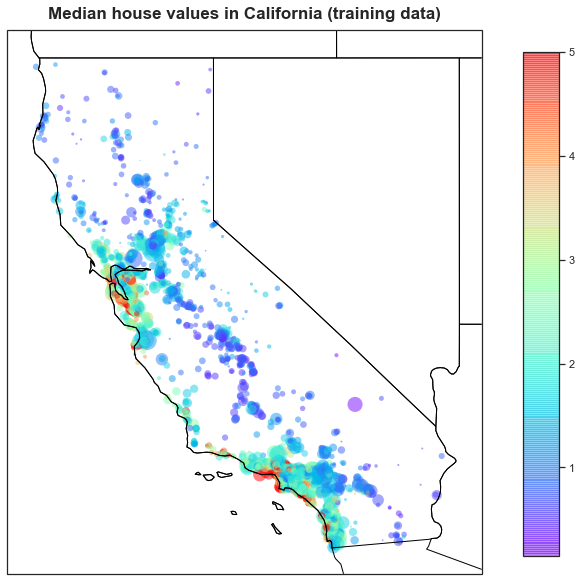

In [20]:
# This code is just for running - advanced code

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Latitude and longitude for the edges of the map
lat1, lat2, lon1, lon2 = 32, 42.5, -125, -114

# Create figures
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection = ccrs.Mercator())

# Get latitude and longitude for each data point
x = train['Longitude'].to_numpy()
y = train['Latitude'].to_numpy()

# Scatter plot as heat map
im = ax.scatter(x, y, s=(train['Population'].to_numpy()/30.0), c=train['MedianHouseValue'].to_numpy(), 
                edgecolors='none', cmap=plt.get_cmap('rainbow'), alpha=0.5, transform=ccrs.PlateCarree())

# Add state borders and coast line
ax.add_feature(cfeature.STATES.with_scale('50m'))
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.set_extent([-125, -113.5, 32, 42.5], crs=ccrs.PlateCarree())

# Add colorbar
cax = fig.add_axes([0.9, 0.15, 0.05, 0.7])  #  [left, bottom, width, height] of the new Axes
fig.colorbar(im, cax=cax, orientation='vertical')

# Add title
ax.set_title('Median house values in California (training data)', fontsize=17, y=1.01, fontweight='bold')

plt.show()

The two variables with strongest linear relationship with house values are the median income and the average occupancy. Further exploration through the scatter plots below reveal nonlinear patterns for the median income, average rooms, and average occupancy. Population, housing average age, and average bedrooms seem to have only weak relationships with house values. 

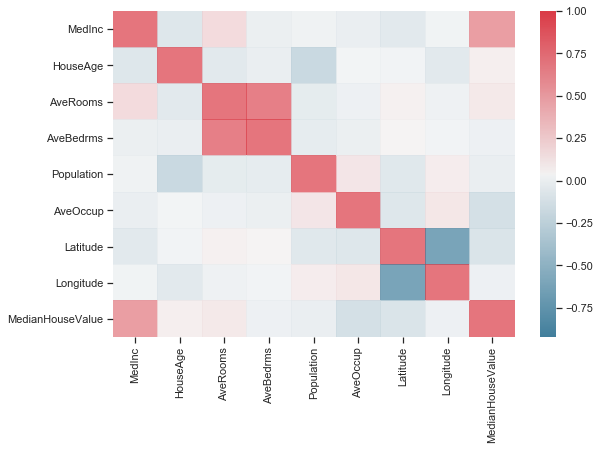

In [21]:
# This code is just for running - we need the figure to support the discussion

# sns.heatmap(train.corr(), cmap=plt.get_cmap('rainbow'), alpha=0.7)
sns.heatmap(train.corr(), cmap=sns.diverging_palette(230, 10, n=1001), alpha=0.7)
plt.show()

The next cell shows the scatter plots for the predictors other than the latitude and longitude. We observe severe outliers in some of them, which as we will see below causes serious problems for the linear regression model. In contrast, tree-based methods are outliers in the predictor space.  We can also that the values of the `MedInc` response variable and `HouseAge` are truncated.

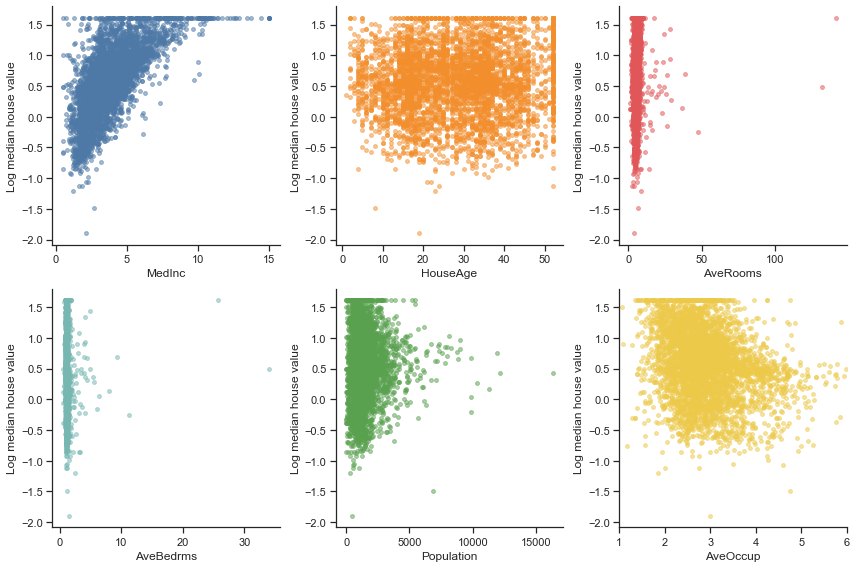

In [22]:
# This code is just for running - we need the figure to support the discussion

fig, axes = plt.subplots(2,3, figsize=(12,8))

for i, ax in enumerate(fig.axes):
    sns.regplot(train.iloc[:,i], y_train, color=colours[i], scatter_kws = {'s': 15, 'alpha': 0.5}, 
                ax=ax, fit_reg=False)
    ax.set_ylabel('Log median house value')

ax.set_xlim(1, 6) # fixes a bug in the last plot

sns.despine()
plt.tight_layout()
plt.show()

# 3. Boosting

This section focuses on the simplest ways of fitting boosted tree models: scikit-learn, the scikit-learn APIs for XGBoost and LightGBM, and CatBoost. 

## 3.1 Scikit-Learn

We start with the scikit-learn implementation of boosting available in the [<TT>GradientBoostingRegressor</TT>](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) class. Recall that boosting has three crucial hyperparameters:

<ol>
<li style="margin-top:15px; margin-bottom: 10px"> The learning rate.</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The number of boosting of iterations (the number trees).</li> 

<li style="margin-top:10px; margin-bottom: 10px"> The size of each tree.</li> 
</ol>

In addition, we may want to to fit each tree on a different subsample of the training data.

The basic syntax is as follows. This section uses pre-selected hyperparameters to save time. The next section will dicuss hyperparameter optimisation for boosting in detail.

In [11]:
%%time

from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1901, subsample=0.596)
gb.fit(X_train, y_train)

CPU times: user 24.2 s, sys: 420 ms, total: 24.7 s
Wall time: 25.3 s


GradientBoostingRegressor(learning_rate=0.01, max_depth=8, n_estimators=1901,
                          subsample=0.596)

We can make a variable importance plot to help with interpretation.

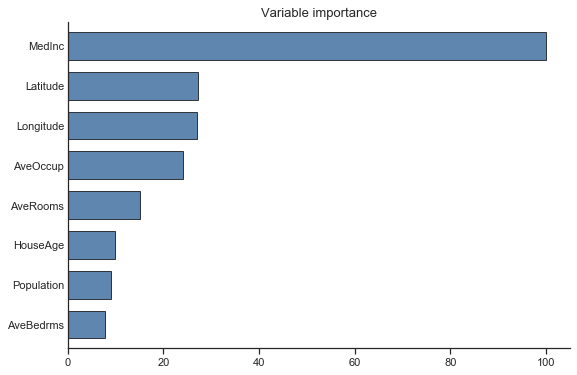

In [21]:
plot_feature_importance(gb, predictors)
plt.show()

Recent versions of scikit-learn introduced the [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html) class, a histogram-based implementation of boosting inspired by LightGBM.  This implementation is significantly faster than `GradientBoostingRegressor` for large datasets.

The available hyperparameters are a bit different for `HistGradientBoostingRegressor`, see the documentation for details.

In [49]:
import sklearn
sklearn.__version__

'0.24.2'

In [21]:
%%time
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import HistGradientBoostingRegressor

# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingRegressor

hgb = HistGradientBoostingRegressor(learning_rate=0.01, max_depth=8, max_iter=1901)
hgb.fit(X_train, y_train)

CPU times: user 1min 47s, sys: 6.21 s, total: 1min 54s
Wall time: 19.4 s


HistGradientBoostingRegressor(learning_rate=0.01, max_depth=8, max_iter=1901)

## 3.2 XGBoost (Scikit-Learn API)

[XGBoost](https://xgboost.readthedocs.io/en/latest/) is a state-of-art gradient boosting library that is very popular among data scientist and [Kaggle](https://www.kaggle.com/) users. 

The easiest way to get started with XGBoost is to use the [scikit-learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn) provided by the package. The syntax is similar to the one before, except that we call the [XGBRegressor](http://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor) class from the XGBoost package. 

XGBoost has significantly more [hyperparameters and options](https://xgboost.readthedocs.io/en/latest/parameter.html) than the scikit-learn implementations of boosting. The code shows the hyperparameters and settings that are most commonly adjusted.

In [22]:
%%time

import xgboost as xgb

xgbst = xgb.XGBRegressor(objective='reg:squarederror', booster = 'gbtree', learning_rate = 0.02, 
                         max_depth = 6, n_estimators = 1822, subsample = 0.60,  reg_lambda=0.0, 
                         reg_alpha = 0.0, colsample_bytree = 1.0, min_child_weight = 1.0)

# n_estimators: number of trees
# subsample: fraction of observations used to fit each tree
# reg_lambda: L2 regularisation penalty
# reg_alpha: L1 regularisation penalty
# colsample_bytree: fraction of features considered for each tree (alternatives: bylevel, bynode)
# min_child_weight: approximately equal to the minimum number of samples in each node

xgbst.fit(X_train, y_train)

CPU times: user 40.5 s, sys: 2.12 s, total: 42.6 s
Wall time: 8.77 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=6,
             min_child_weight=1.0, missing=nan, monotone_constraints='()',
             n_estimators=1822, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=None)

Other useful features supported by this API include: 

* Early stopping (we'll cover this below in the context of LightGBM).

* Pruning (the `gamma` parameter is a penalty for the number of leaves).
                  
* Mononicity constraints.

* Interaction contraints.

* GPU training.

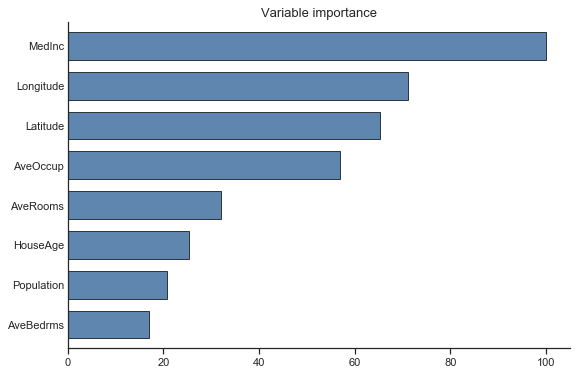

In [25]:
plot_feature_importance(xgbst, labels=predictors)
plt.show()

## 3.3 LightGBM (Scikit-Learn API)

[LightGBM](http://lightgbm.readthedocs.io/en/latest/index.html) is a gradient boosting library developed by Microsoft. Similarly to XGBoost, it has a [scikit-learn API](http://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api) that makes it simple to use. Conveniently, the implementation is very computationally efficient. 

Like XGBoost, LightGBM has a [large number](https://lightgbm.readthedocs.io/en/latest/Parameters.html) of configuration options. The code highlights the most important parameters to pay attention to.

Because of the way LightGBM [works](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc), we set the number of leaves rather than the maximum tree depth as in XGBoost. 

In [12]:
%%time

import lightgbm as lgb

lgbm = lgb.LGBMRegressor(objective='regression', boosting_type = 'gbdt', 
                         n_estimators=1974, learning_rate=0.01,
                         num_leaves=24,
                         lambda_l1=0.0, lambda_l2=0.0,
                         bagging_fraction=0.74, bagging_freq=1, 
                         feature_fraction=1.0, min_data_in_leaf=1)

lgbm = lgbm.fit(X_train, y_train)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.74, subsample=1.0 will be ignored. Current value: bagging_fraction=0.74
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
CPU times: user 17.2 s, sys: 945 ms, total: 18.2 s
Wall time: 3.9 s


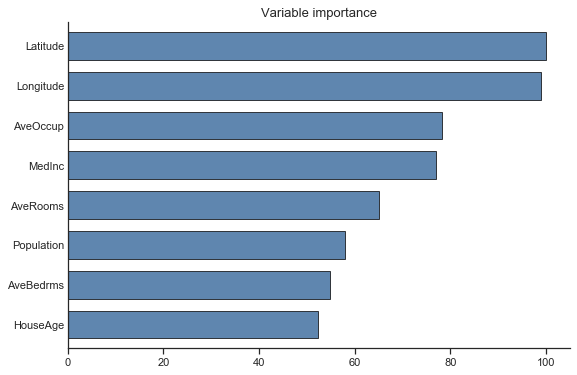

In [23]:
plot_feature_importance(lgbm, labels=predictors)
plt.show()

## 3.4 CatBoost

[CatBoost](https://catboost.ai/) is another important gradient boosting library. The main advantages of CatBoost is its great support for categorical features and computational speed. 

We use the [CatBoostRegressor](https://catboost.ai/en/docs/concepts/python-reference_catboostregressor) class, which works like a scikit-learn estimator. See the [documentation](https://catboost.ai/en/docs/references/training-parameters/) for the full list of parameters. 

The following cell is just to illustrate the syntax.

In [24]:
%%time

from catboost import CatBoostRegressor

cb = CatBoostRegressor(loss_function='RMSE', 
                       iterations = 2000, 
                       learning_rate = 0.01,
                       l2_leaf_reg = 0.0,
                       max_depth = 6, 
                       subsample = 0.8, 
                       verbose=0)
        
cb.fit(X_train, y_train)

# Important! If there were categorical features, you'd want to change the code to
# cb.fit(X_train, y_train, cat_features = cat_indices)
# where cat_indices is a one-dimensional array of indices indicating the categorical columns in X_train

CPU times: user 15.6 s, sys: 1.32 s, total: 16.9 s
Wall time: 3.96 s


The CatBoost [website](https://catboost.ai/) claims that the package provides great result with default parameters. Let's put this to test.

In [30]:
cb = CatBoostRegressor(loss_function='RMSE', verbose=0)        
cb.fit(X_train, y_train)

# 4. LightGBM: a deeper dive

LightGBM, XGBoost, and CatBoost are extremely useful libraries at the forefront of current machine learning practice. Therefore, you should try to learn at least one of these three packages as deeply as you can.

Because we only have time for one, we'll cover LightGBM. However, XGBoost and CatBoost are just as good. Either of the three may perform best for a given problem.

## 4.1 Training API 

We now use switch to native API, which is faster and worth learning. First, we need to convert the dataset into the LightGBM format. The LightGBM format is optimised for the learning algorithm and consumes less memory, which is important if you're working with large datasets.

In [31]:
train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference=train_data)

# An important detail that is not applicable to this tutorial is that LightGBM can handle
# categorical features in a specialised way, without the need for prior encoding.

# Suppose that that the first two columns of X_train are categorical. You'd then run:
# train_data = lgb.Dataset(X_train, y_train, categorical_feature = [0, 1])

# Alternatively, you can pass the list of categorical features to the train function below

To train the model, we create a dictionary with the hyperparameters and settings and pass it the train function. As an additional detail, we also pass the validation set for evaluation. 

See the [documentation](https://lightgbm.readthedocs.io/en/latest/Parameters.html#) for the full list of parameters. 

In [50]:
%%time

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'l2',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'lambda_l1': 0.0, 
    'lambda_l2': 0.0, 
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 20, 
}

evals = {} 

lgbm = lgb.train(params, train_data, num_boost_round = 2000, valid_sets = [train_data, valid_data], 
                 valid_names=['Training', 'Validation'], evals_result = evals)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 4128, number of used features: 8
[LightGBM] [Info] Start training from score 0.573084
[1]	Training's l2: 0.317312	Validation's l2: 0.320228
[2]	Training's l2: 0.313352	Validation's l2: 0.316392
[3]	Training's l2: 0.309144	Validation's l2: 0.312346
[4]	Training's l2: 0.305328	Validation's l2: 0.308652
[5]	Training's l2: 0.301519	Validation's l2: 0.30503
[6]	Training's l2: 0.297377	Validation's l2: 0.300985
[7]	Training's l2: 0.29339	Validation's l2: 0.297044
[8]	Training's l2: 0.289693	Validation's l2: 0.293473
[9]	Training's l2: 0.285778	Validation's l2: 0.289653
[10]	Training's l2: 0.282222	Validation's l2: 0.286211
[11]	Training's l2: 0.278775	Validation's l2: 0.282902
[12]	Training's l2: 0.2754	Validation's l2: 0.279633
[13]	Train

[154]	Training's l2: 0.0810568	Validation's l2: 0.0932127
[155]	Training's l2: 0.0806016	Validation's l2: 0.0927777
[156]	Training's l2: 0.0800775	Validation's l2: 0.0922689
[157]	Training's l2: 0.0797388	Validation's l2: 0.0919722
[158]	Training's l2: 0.0793247	Validation's l2: 0.0915907
[159]	Training's l2: 0.0788407	Validation's l2: 0.0911174
[160]	Training's l2: 0.0784399	Validation's l2: 0.0907467
[161]	Training's l2: 0.0781115	Validation's l2: 0.0904691
[162]	Training's l2: 0.0777171	Validation's l2: 0.0901061
[163]	Training's l2: 0.0773329	Validation's l2: 0.0897461
[164]	Training's l2: 0.0769097	Validation's l2: 0.0893551
[165]	Training's l2: 0.0765347	Validation's l2: 0.0890105
[166]	Training's l2: 0.0761696	Validation's l2: 0.0886791
[167]	Training's l2: 0.0758765	Validation's l2: 0.0884293
[168]	Training's l2: 0.0755899	Validation's l2: 0.0881823
[169]	Training's l2: 0.0752865	Validation's l2: 0.087915
[170]	Training's l2: 0.0749911	Validation's l2: 0.0876554
[171]	Training'

[299]	Training's l2: 0.0505079	Validation's l2: 0.0666351
[300]	Training's l2: 0.0503788	Validation's l2: 0.0665137
[301]	Training's l2: 0.0502582	Validation's l2: 0.0664218
[302]	Training's l2: 0.0501386	Validation's l2: 0.0663259
[303]	Training's l2: 0.0500223	Validation's l2: 0.0662362
[304]	Training's l2: 0.0499482	Validation's l2: 0.0661966
[305]	Training's l2: 0.0498324	Validation's l2: 0.0661045
[306]	Training's l2: 0.0497036	Validation's l2: 0.065992
[307]	Training's l2: 0.0496304	Validation's l2: 0.0659575
[308]	Training's l2: 0.0495029	Validation's l2: 0.0658514
[309]	Training's l2: 0.0493787	Validation's l2: 0.0657482
[310]	Training's l2: 0.0492575	Validation's l2: 0.0656474
[311]	Training's l2: 0.0490976	Validation's l2: 0.0655001
[312]	Training's l2: 0.0489544	Validation's l2: 0.0653621
[313]	Training's l2: 0.0488342	Validation's l2: 0.0652513
[314]	Training's l2: 0.0487145	Validation's l2: 0.0651478
[315]	Training's l2: 0.04863	Validation's l2: 0.0651018
[316]	Training's 

[465]	Training's l2: 0.0382411	Validation's l2: 0.0580559
[466]	Training's l2: 0.0382028	Validation's l2: 0.0580342
[467]	Training's l2: 0.0381524	Validation's l2: 0.0580074
[468]	Training's l2: 0.0381166	Validation's l2: 0.0580021
[469]	Training's l2: 0.0380778	Validation's l2: 0.0579876
[470]	Training's l2: 0.0380311	Validation's l2: 0.0579621
[471]	Training's l2: 0.0379847	Validation's l2: 0.057934
[472]	Training's l2: 0.0379289	Validation's l2: 0.0578996
[473]	Training's l2: 0.0378777	Validation's l2: 0.0578802
[474]	Training's l2: 0.0378275	Validation's l2: 0.0578616
[475]	Training's l2: 0.0377815	Validation's l2: 0.0578448
[476]	Training's l2: 0.0377389	Validation's l2: 0.0578134
[477]	Training's l2: 0.0376972	Validation's l2: 0.0577828
[478]	Training's l2: 0.0376604	Validation's l2: 0.0577716
[479]	Training's l2: 0.0376205	Validation's l2: 0.0577467
[480]	Training's l2: 0.0375723	Validation's l2: 0.0577201
[481]	Training's l2: 0.0375307	Validation's l2: 0.0577117
[482]	Training'

[633]	Training's l2: 0.0322125	Validation's l2: 0.0558004
[634]	Training's l2: 0.0321798	Validation's l2: 0.0557934
[635]	Training's l2: 0.0321499	Validation's l2: 0.0557807
[636]	Training's l2: 0.0321209	Validation's l2: 0.0557768
[637]	Training's l2: 0.0320983	Validation's l2: 0.0557712
[638]	Training's l2: 0.0320681	Validation's l2: 0.0557594
[639]	Training's l2: 0.0320433	Validation's l2: 0.0557542
[640]	Training's l2: 0.0320207	Validation's l2: 0.055754
[641]	Training's l2: 0.0319974	Validation's l2: 0.0557498
[642]	Training's l2: 0.0319666	Validation's l2: 0.055736
[643]	Training's l2: 0.0319426	Validation's l2: 0.0557325
[644]	Training's l2: 0.0319157	Validation's l2: 0.0557289
[645]	Training's l2: 0.0318896	Validation's l2: 0.0557263
[646]	Training's l2: 0.0318596	Validation's l2: 0.0557202
[647]	Training's l2: 0.0318316	Validation's l2: 0.0557136
[648]	Training's l2: 0.0318025	Validation's l2: 0.055708
[649]	Training's l2: 0.0317755	Validation's l2: 0.055702
[650]	Training's l

[778]	Training's l2: 0.0284538	Validation's l2: 0.0547798
[779]	Training's l2: 0.0284284	Validation's l2: 0.0547758
[780]	Training's l2: 0.0284097	Validation's l2: 0.054765
[781]	Training's l2: 0.0283867	Validation's l2: 0.0547619
[782]	Training's l2: 0.028364	Validation's l2: 0.0547618
[783]	Training's l2: 0.0283403	Validation's l2: 0.0547624
[784]	Training's l2: 0.0283176	Validation's l2: 0.0547591
[785]	Training's l2: 0.0282963	Validation's l2: 0.0547595
[786]	Training's l2: 0.0282759	Validation's l2: 0.0547644
[787]	Training's l2: 0.0282549	Validation's l2: 0.0547608
[788]	Training's l2: 0.0282342	Validation's l2: 0.0547571
[789]	Training's l2: 0.0282133	Validation's l2: 0.0547529
[790]	Training's l2: 0.0281936	Validation's l2: 0.0547581
[791]	Training's l2: 0.0281753	Validation's l2: 0.0547572
[792]	Training's l2: 0.0281584	Validation's l2: 0.0547539
[793]	Training's l2: 0.0281382	Validation's l2: 0.0547496
[794]	Training's l2: 0.0281208	Validation's l2: 0.0547487
[795]	Training's

[943]	Training's l2: 0.0252113	Validation's l2: 0.0540633
[944]	Training's l2: 0.0251922	Validation's l2: 0.0540605
[945]	Training's l2: 0.0251714	Validation's l2: 0.0540594
[946]	Training's l2: 0.025152	Validation's l2: 0.0540548
[947]	Training's l2: 0.0251319	Validation's l2: 0.05405
[948]	Training's l2: 0.0251155	Validation's l2: 0.0540401
[949]	Training's l2: 0.0250945	Validation's l2: 0.0540372
[950]	Training's l2: 0.0250752	Validation's l2: 0.0540302
[951]	Training's l2: 0.0250549	Validation's l2: 0.0540287
[952]	Training's l2: 0.025036	Validation's l2: 0.0540193
[953]	Training's l2: 0.02502	Validation's l2: 0.0540193
[954]	Training's l2: 0.0250001	Validation's l2: 0.0540178
[955]	Training's l2: 0.0249811	Validation's l2: 0.0540076
[956]	Training's l2: 0.0249644	Validation's l2: 0.0540017
[957]	Training's l2: 0.0249491	Validation's l2: 0.0539966
[958]	Training's l2: 0.0249321	Validation's l2: 0.0539937
[959]	Training's l2: 0.0249134	Validation's l2: 0.0539936
[960]	Training's l2:

[1090]	Training's l2: 0.0227651	Validation's l2: 0.0536637
[1091]	Training's l2: 0.0227448	Validation's l2: 0.0536576
[1092]	Training's l2: 0.0227279	Validation's l2: 0.0536569
[1093]	Training's l2: 0.0227119	Validation's l2: 0.0536555
[1094]	Training's l2: 0.0226913	Validation's l2: 0.0536517
[1095]	Training's l2: 0.0226771	Validation's l2: 0.0536455
[1096]	Training's l2: 0.0226632	Validation's l2: 0.053646
[1097]	Training's l2: 0.0226476	Validation's l2: 0.0536472
[1098]	Training's l2: 0.0226332	Validation's l2: 0.0536493
[1099]	Training's l2: 0.0226185	Validation's l2: 0.0536487
[1100]	Training's l2: 0.022605	Validation's l2: 0.053649
[1101]	Training's l2: 0.0225885	Validation's l2: 0.0536465
[1102]	Training's l2: 0.0225716	Validation's l2: 0.0536432
[1103]	Training's l2: 0.0225545	Validation's l2: 0.0536402
[1104]	Training's l2: 0.0225381	Validation's l2: 0.0536369
[1105]	Training's l2: 0.0225228	Validation's l2: 0.0536377
[1106]	Training's l2: 0.022508	Validation's l2: 0.0536348
[

[1260]	Training's l2: 0.0204282	Validation's l2: 0.0533377
[1261]	Training's l2: 0.0204161	Validation's l2: 0.0533382
[1262]	Training's l2: 0.020405	Validation's l2: 0.0533389
[1263]	Training's l2: 0.0203931	Validation's l2: 0.053336
[1264]	Training's l2: 0.0203814	Validation's l2: 0.0533338
[1265]	Training's l2: 0.0203708	Validation's l2: 0.0533346
[1266]	Training's l2: 0.0203558	Validation's l2: 0.0533312
[1267]	Training's l2: 0.0203405	Validation's l2: 0.0533281
[1268]	Training's l2: 0.0203262	Validation's l2: 0.0533242
[1269]	Training's l2: 0.0203114	Validation's l2: 0.0533202
[1270]	Training's l2: 0.0202975	Validation's l2: 0.053317
[1271]	Training's l2: 0.020284	Validation's l2: 0.0533154
[1272]	Training's l2: 0.0202689	Validation's l2: 0.0533105
[1273]	Training's l2: 0.0202567	Validation's l2: 0.0533079
[1274]	Training's l2: 0.0202446	Validation's l2: 0.0533068
[1275]	Training's l2: 0.0202303	Validation's l2: 0.0533076
[1276]	Training's l2: 0.0202163	Validation's l2: 0.053306
[1

[1413]	Training's l2: 0.0186242	Validation's l2: 0.0530901
[1414]	Training's l2: 0.0186143	Validation's l2: 0.0530867
[1415]	Training's l2: 0.0186061	Validation's l2: 0.053084
[1416]	Training's l2: 0.0185945	Validation's l2: 0.0530782
[1417]	Training's l2: 0.0185819	Validation's l2: 0.0530759
[1418]	Training's l2: 0.0185694	Validation's l2: 0.0530716
[1419]	Training's l2: 0.0185607	Validation's l2: 0.0530704
[1420]	Training's l2: 0.018549	Validation's l2: 0.0530676
[1421]	Training's l2: 0.0185368	Validation's l2: 0.0530612
[1422]	Training's l2: 0.0185259	Validation's l2: 0.0530583
[1423]	Training's l2: 0.0185147	Validation's l2: 0.0530569
[1424]	Training's l2: 0.0185038	Validation's l2: 0.0530556
[1425]	Training's l2: 0.0184928	Validation's l2: 0.0530522
[1426]	Training's l2: 0.0184816	Validation's l2: 0.0530496
[1427]	Training's l2: 0.0184697	Validation's l2: 0.053052
[1428]	Training's l2: 0.0184579	Validation's l2: 0.0530499
[1429]	Training's l2: 0.0184481	Validation's l2: 0.0530468


[1578]	Training's l2: 0.0169015	Validation's l2: 0.0528739
[1579]	Training's l2: 0.0168926	Validation's l2: 0.052871
[1580]	Training's l2: 0.0168847	Validation's l2: 0.0528648
[1581]	Training's l2: 0.0168746	Validation's l2: 0.0528654
[1582]	Training's l2: 0.0168651	Validation's l2: 0.0528612
[1583]	Training's l2: 0.0168539	Validation's l2: 0.0528624
[1584]	Training's l2: 0.0168449	Validation's l2: 0.0528638
[1585]	Training's l2: 0.0168355	Validation's l2: 0.0528644
[1586]	Training's l2: 0.0168269	Validation's l2: 0.0528671
[1587]	Training's l2: 0.0168178	Validation's l2: 0.0528674
[1588]	Training's l2: 0.0168073	Validation's l2: 0.0528669
[1589]	Training's l2: 0.0167972	Validation's l2: 0.0528666
[1590]	Training's l2: 0.0167888	Validation's l2: 0.0528701
[1591]	Training's l2: 0.0167784	Validation's l2: 0.0528692
[1592]	Training's l2: 0.0167697	Validation's l2: 0.0528744
[1593]	Training's l2: 0.0167591	Validation's l2: 0.0528713
[1594]	Training's l2: 0.0167509	Validation's l2: 0.052874

[1728]	Training's l2: 0.0155544	Validation's l2: 0.0528004
[1729]	Training's l2: 0.0155461	Validation's l2: 0.0527978
[1730]	Training's l2: 0.015535	Validation's l2: 0.0527991
[1731]	Training's l2: 0.0155262	Validation's l2: 0.0528001
[1732]	Training's l2: 0.0155176	Validation's l2: 0.0527997
[1733]	Training's l2: 0.0155081	Validation's l2: 0.0527999
[1734]	Training's l2: 0.0154992	Validation's l2: 0.0527994
[1735]	Training's l2: 0.0154914	Validation's l2: 0.0527998
[1736]	Training's l2: 0.0154816	Validation's l2: 0.0527953
[1737]	Training's l2: 0.015472	Validation's l2: 0.0527917
[1738]	Training's l2: 0.0154625	Validation's l2: 0.0527883
[1739]	Training's l2: 0.0154536	Validation's l2: 0.0527831
[1740]	Training's l2: 0.0154442	Validation's l2: 0.0527833
[1741]	Training's l2: 0.0154359	Validation's l2: 0.0527845
[1742]	Training's l2: 0.0154279	Validation's l2: 0.0527852
[1743]	Training's l2: 0.0154203	Validation's l2: 0.0527834
[1744]	Training's l2: 0.0154121	Validation's l2: 0.0527847

[1869]	Training's l2: 0.0144111	Validation's l2: 0.0526907
[1870]	Training's l2: 0.0144022	Validation's l2: 0.0526889
[1871]	Training's l2: 0.0143964	Validation's l2: 0.0526872
[1872]	Training's l2: 0.01439	Validation's l2: 0.0526861
[1873]	Training's l2: 0.0143843	Validation's l2: 0.0526845
[1874]	Training's l2: 0.0143765	Validation's l2: 0.0526851
[1875]	Training's l2: 0.0143696	Validation's l2: 0.0526827
[1876]	Training's l2: 0.0143626	Validation's l2: 0.0526801
[1877]	Training's l2: 0.0143544	Validation's l2: 0.0526794
[1878]	Training's l2: 0.0143462	Validation's l2: 0.0526783
[1879]	Training's l2: 0.0143372	Validation's l2: 0.0526777
[1880]	Training's l2: 0.0143301	Validation's l2: 0.0526778
[1881]	Training's l2: 0.0143232	Validation's l2: 0.0526763
[1882]	Training's l2: 0.0143152	Validation's l2: 0.0526772
[1883]	Training's l2: 0.0143084	Validation's l2: 0.0526767
[1884]	Training's l2: 0.0143017	Validation's l2: 0.0526753
[1885]	Training's l2: 0.014295	Validation's l2: 0.0526733


The `plot_metric` function allows you to plot the training and validation errors against the number of trees. Fortunately, boosting is slow to overfit.

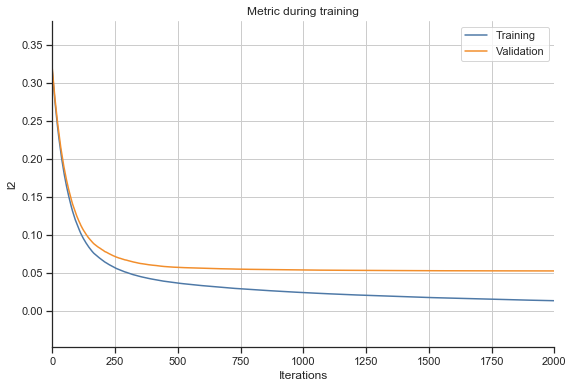

In [51]:
lgb.plot_metric(evals, metric = 'l2')
sns.despine()
plt.show()

## 4.2 Early stopping 

In the following example, we activate early stopping by setting the `early_stopping_rounds` parameter. In this case, LightGBM will stop training when the validation scores don't improve for 50 iterations. 

In [33]:
%%time

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'lambda_l1': 0.0, 
    'lambda_l2': 0.0, 
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 20,
}

evals = {} 

lgbm = lgb.train(params, train_data, num_boost_round = 5000,  valid_sets = [train_data, valid_data], 
                 valid_names=['Training', 'Validation'], early_stopping_rounds = 100,  evals_result = evals)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 4128, number of used features: 8
[LightGBM] [Info] Start training from score 0.573084
[1]	Training's l2: 0.317312	Validation's l2: 0.320228
Training until validation scores don't improve for 100 rounds
[2]	Training's l2: 0.313352	Validation's l2: 0.316392
[3]	Training's l2: 0.309144	Validation's l2: 0.312346
[4]	Training's l2: 0.305328	Validation's l2: 0.308652
[5]	Training's l2: 0.301519	Validation's l2: 0.30503
[6]	Training's l2: 0.297377	Validation's l2: 0.300985
[7]	Training's l2: 0.29339	Validation's l2: 0.297044
[8]	Training's l2: 0.289693	Validation's l2: 0.293473
[9]	Training's l2: 0.285778	Validation's l2: 0.289653
[10]	Training's l2: 0.282222	Validation's l2: 0.286211
[11]	Training's l2: 0.278775	Validation's l2: 0.282902
[

[164]	Training's l2: 0.0769097	Validation's l2: 0.0893551
[165]	Training's l2: 0.0765347	Validation's l2: 0.0890105
[166]	Training's l2: 0.0761696	Validation's l2: 0.0886791
[167]	Training's l2: 0.0758765	Validation's l2: 0.0884293
[168]	Training's l2: 0.0755899	Validation's l2: 0.0881823
[169]	Training's l2: 0.0752865	Validation's l2: 0.087915
[170]	Training's l2: 0.0749911	Validation's l2: 0.0876554
[171]	Training's l2: 0.074722	Validation's l2: 0.0874157
[172]	Training's l2: 0.0744021	Validation's l2: 0.0871129
[173]	Training's l2: 0.0740967	Validation's l2: 0.086829
[174]	Training's l2: 0.0737959	Validation's l2: 0.0865577
[175]	Training's l2: 0.0735336	Validation's l2: 0.0863349
[176]	Training's l2: 0.0732688	Validation's l2: 0.0861247
[177]	Training's l2: 0.0730196	Validation's l2: 0.0859054
[178]	Training's l2: 0.0727079	Validation's l2: 0.0856098
[179]	Training's l2: 0.0723987	Validation's l2: 0.0853346
[180]	Training's l2: 0.0720972	Validation's l2: 0.0850555
[181]	Training's 

[309]	Training's l2: 0.0493787	Validation's l2: 0.0657482
[310]	Training's l2: 0.0492575	Validation's l2: 0.0656474
[311]	Training's l2: 0.0490976	Validation's l2: 0.0655001
[312]	Training's l2: 0.0489544	Validation's l2: 0.0653621
[313]	Training's l2: 0.0488342	Validation's l2: 0.0652513
[314]	Training's l2: 0.0487145	Validation's l2: 0.0651478
[315]	Training's l2: 0.04863	Validation's l2: 0.0651018
[316]	Training's l2: 0.0485259	Validation's l2: 0.0650066
[317]	Training's l2: 0.0484265	Validation's l2: 0.0649154
[318]	Training's l2: 0.048327	Validation's l2: 0.0648243
[319]	Training's l2: 0.0482573	Validation's l2: 0.0647886
[320]	Training's l2: 0.0481222	Validation's l2: 0.0646645
[321]	Training's l2: 0.0480143	Validation's l2: 0.0645874
[322]	Training's l2: 0.047919	Validation's l2: 0.0645131
[323]	Training's l2: 0.0478113	Validation's l2: 0.0644351
[324]	Training's l2: 0.0477353	Validation's l2: 0.0644053
[325]	Training's l2: 0.0476462	Validation's l2: 0.0643341
[326]	Training's l

[461]	Training's l2: 0.0384228	Validation's l2: 0.0581529
[462]	Training's l2: 0.0383824	Validation's l2: 0.0581324
[463]	Training's l2: 0.038338	Validation's l2: 0.0581141
[464]	Training's l2: 0.0382933	Validation's l2: 0.0580875
[465]	Training's l2: 0.0382411	Validation's l2: 0.0580559
[466]	Training's l2: 0.0382028	Validation's l2: 0.0580342
[467]	Training's l2: 0.0381524	Validation's l2: 0.0580074
[468]	Training's l2: 0.0381166	Validation's l2: 0.0580021
[469]	Training's l2: 0.0380778	Validation's l2: 0.0579876
[470]	Training's l2: 0.0380311	Validation's l2: 0.0579621
[471]	Training's l2: 0.0379847	Validation's l2: 0.057934
[472]	Training's l2: 0.0379289	Validation's l2: 0.0578996
[473]	Training's l2: 0.0378777	Validation's l2: 0.0578802
[474]	Training's l2: 0.0378275	Validation's l2: 0.0578616
[475]	Training's l2: 0.0377815	Validation's l2: 0.0578448
[476]	Training's l2: 0.0377389	Validation's l2: 0.0578134
[477]	Training's l2: 0.0376972	Validation's l2: 0.0577828
[478]	Training's

[614]	Training's l2: 0.0328082	Validation's l2: 0.0559661
[615]	Training's l2: 0.0327806	Validation's l2: 0.0559514
[616]	Training's l2: 0.0327505	Validation's l2: 0.0559474
[617]	Training's l2: 0.0327198	Validation's l2: 0.0559401
[618]	Training's l2: 0.0326879	Validation's l2: 0.0559352
[619]	Training's l2: 0.0326598	Validation's l2: 0.055931
[620]	Training's l2: 0.0326265	Validation's l2: 0.0559169
[621]	Training's l2: 0.0325963	Validation's l2: 0.055912
[622]	Training's l2: 0.0325641	Validation's l2: 0.0559052
[623]	Training's l2: 0.0325343	Validation's l2: 0.0559051
[624]	Training's l2: 0.0325058	Validation's l2: 0.0559048
[625]	Training's l2: 0.0324669	Validation's l2: 0.0558883
[626]	Training's l2: 0.0324281	Validation's l2: 0.0558667
[627]	Training's l2: 0.0323969	Validation's l2: 0.0558618
[628]	Training's l2: 0.0323618	Validation's l2: 0.0558472
[629]	Training's l2: 0.0323331	Validation's l2: 0.055836
[630]	Training's l2: 0.0322997	Validation's l2: 0.0558163
[631]	Training's 

[782]	Training's l2: 0.028364	Validation's l2: 0.0547618
[783]	Training's l2: 0.0283403	Validation's l2: 0.0547624
[784]	Training's l2: 0.0283176	Validation's l2: 0.0547591
[785]	Training's l2: 0.0282963	Validation's l2: 0.0547595
[786]	Training's l2: 0.0282759	Validation's l2: 0.0547644
[787]	Training's l2: 0.0282549	Validation's l2: 0.0547608
[788]	Training's l2: 0.0282342	Validation's l2: 0.0547571
[789]	Training's l2: 0.0282133	Validation's l2: 0.0547529
[790]	Training's l2: 0.0281936	Validation's l2: 0.0547581
[791]	Training's l2: 0.0281753	Validation's l2: 0.0547572
[792]	Training's l2: 0.0281584	Validation's l2: 0.0547539
[793]	Training's l2: 0.0281382	Validation's l2: 0.0547496
[794]	Training's l2: 0.0281208	Validation's l2: 0.0547487
[795]	Training's l2: 0.0280986	Validation's l2: 0.0547462
[796]	Training's l2: 0.0280763	Validation's l2: 0.0547459
[797]	Training's l2: 0.0280496	Validation's l2: 0.0547307
[798]	Training's l2: 0.0280277	Validation's l2: 0.0547202
[799]	Training'

[976]	Training's l2: 0.0245957	Validation's l2: 0.0539534
[977]	Training's l2: 0.024579	Validation's l2: 0.0539489
[978]	Training's l2: 0.0245614	Validation's l2: 0.0539431
[979]	Training's l2: 0.0245445	Validation's l2: 0.0539387
[980]	Training's l2: 0.0245289	Validation's l2: 0.0539352
[981]	Training's l2: 0.0245151	Validation's l2: 0.0539315
[982]	Training's l2: 0.0244966	Validation's l2: 0.0539245
[983]	Training's l2: 0.0244733	Validation's l2: 0.0539181
[984]	Training's l2: 0.0244554	Validation's l2: 0.0539118
[985]	Training's l2: 0.0244333	Validation's l2: 0.0539069
[986]	Training's l2: 0.0244188	Validation's l2: 0.0539077
[987]	Training's l2: 0.0244012	Validation's l2: 0.0539051
[988]	Training's l2: 0.0243875	Validation's l2: 0.0539061
[989]	Training's l2: 0.0243677	Validation's l2: 0.0538976
[990]	Training's l2: 0.024352	Validation's l2: 0.0538968
[991]	Training's l2: 0.0243371	Validation's l2: 0.0538969
[992]	Training's l2: 0.0243221	Validation's l2: 0.053896
[993]	Training's 

[1144]	Training's l2: 0.0219579	Validation's l2: 0.0535624
[1145]	Training's l2: 0.0219439	Validation's l2: 0.0535605
[1146]	Training's l2: 0.0219315	Validation's l2: 0.053563
[1147]	Training's l2: 0.0219174	Validation's l2: 0.0535559
[1148]	Training's l2: 0.0219052	Validation's l2: 0.0535576
[1149]	Training's l2: 0.0218887	Validation's l2: 0.0535502
[1150]	Training's l2: 0.0218755	Validation's l2: 0.0535427
[1151]	Training's l2: 0.0218582	Validation's l2: 0.0535407
[1152]	Training's l2: 0.0218409	Validation's l2: 0.0535389
[1153]	Training's l2: 0.0218242	Validation's l2: 0.0535372
[1154]	Training's l2: 0.0218076	Validation's l2: 0.0535342
[1155]	Training's l2: 0.0217916	Validation's l2: 0.0535301
[1156]	Training's l2: 0.0217799	Validation's l2: 0.0535322
[1157]	Training's l2: 0.0217659	Validation's l2: 0.0535296
[1158]	Training's l2: 0.0217513	Validation's l2: 0.0535292
[1159]	Training's l2: 0.0217387	Validation's l2: 0.0535294
[1160]	Training's l2: 0.0217247	Validation's l2: 0.053528

[1311]	Training's l2: 0.0197952	Validation's l2: 0.0532686
[1312]	Training's l2: 0.019779	Validation's l2: 0.0532645
[1313]	Training's l2: 0.0197684	Validation's l2: 0.0532612
[1314]	Training's l2: 0.0197561	Validation's l2: 0.0532621
[1315]	Training's l2: 0.0197453	Validation's l2: 0.0532617
[1316]	Training's l2: 0.0197349	Validation's l2: 0.0532612
[1317]	Training's l2: 0.0197259	Validation's l2: 0.0532647
[1318]	Training's l2: 0.0197162	Validation's l2: 0.0532682
[1319]	Training's l2: 0.0197062	Validation's l2: 0.0532666
[1320]	Training's l2: 0.0196933	Validation's l2: 0.0532637
[1321]	Training's l2: 0.0196788	Validation's l2: 0.0532542
[1322]	Training's l2: 0.0196666	Validation's l2: 0.0532534
[1323]	Training's l2: 0.0196544	Validation's l2: 0.0532536
[1324]	Training's l2: 0.0196442	Validation's l2: 0.0532524
[1325]	Training's l2: 0.0196318	Validation's l2: 0.053247
[1326]	Training's l2: 0.0196217	Validation's l2: 0.053247
[1327]	Training's l2: 0.0196116	Validation's l2: 0.0532455


[1516]	Training's l2: 0.0175083	Validation's l2: 0.0529428
[1517]	Training's l2: 0.0174981	Validation's l2: 0.0529398
[1518]	Training's l2: 0.0174878	Validation's l2: 0.0529382
[1519]	Training's l2: 0.0174774	Validation's l2: 0.052936
[1520]	Training's l2: 0.0174665	Validation's l2: 0.0529325
[1521]	Training's l2: 0.0174554	Validation's l2: 0.0529271
[1522]	Training's l2: 0.0174443	Validation's l2: 0.0529224
[1523]	Training's l2: 0.0174331	Validation's l2: 0.0529218
[1524]	Training's l2: 0.0174233	Validation's l2: 0.0529204
[1525]	Training's l2: 0.0174133	Validation's l2: 0.0529194
[1526]	Training's l2: 0.017403	Validation's l2: 0.0529213
[1527]	Training's l2: 0.0173929	Validation's l2: 0.0529229
[1528]	Training's l2: 0.0173823	Validation's l2: 0.0529201
[1529]	Training's l2: 0.0173739	Validation's l2: 0.0529223
[1530]	Training's l2: 0.0173641	Validation's l2: 0.0529239
[1531]	Training's l2: 0.0173538	Validation's l2: 0.0529195
[1532]	Training's l2: 0.0173451	Validation's l2: 0.0529187

[1659]	Training's l2: 0.0161823	Validation's l2: 0.0528474
[1660]	Training's l2: 0.0161754	Validation's l2: 0.0528439
[1661]	Training's l2: 0.0161656	Validation's l2: 0.0528451
[1662]	Training's l2: 0.0161554	Validation's l2: 0.0528455
[1663]	Training's l2: 0.0161454	Validation's l2: 0.0528458
[1664]	Training's l2: 0.0161346	Validation's l2: 0.0528456
[1665]	Training's l2: 0.0161239	Validation's l2: 0.0528465
[1666]	Training's l2: 0.0161149	Validation's l2: 0.0528484
[1667]	Training's l2: 0.016106	Validation's l2: 0.0528476
[1668]	Training's l2: 0.0160959	Validation's l2: 0.0528482
[1669]	Training's l2: 0.016087	Validation's l2: 0.0528476
[1670]	Training's l2: 0.0160767	Validation's l2: 0.0528488
[1671]	Training's l2: 0.0160691	Validation's l2: 0.0528502
[1672]	Training's l2: 0.0160604	Validation's l2: 0.0528521
[1673]	Training's l2: 0.0160526	Validation's l2: 0.0528506
[1674]	Training's l2: 0.0160411	Validation's l2: 0.0528463
[1675]	Training's l2: 0.0160324	Validation's l2: 0.0528452

[1808]	Training's l2: 0.0148907	Validation's l2: 0.0527336
[1809]	Training's l2: 0.0148831	Validation's l2: 0.0527351
[1810]	Training's l2: 0.0148754	Validation's l2: 0.0527337
[1811]	Training's l2: 0.0148665	Validation's l2: 0.0527329
[1812]	Training's l2: 0.0148583	Validation's l2: 0.0527291
[1813]	Training's l2: 0.0148487	Validation's l2: 0.0527319
[1814]	Training's l2: 0.014839	Validation's l2: 0.052731
[1815]	Training's l2: 0.0148297	Validation's l2: 0.0527264
[1816]	Training's l2: 0.0148233	Validation's l2: 0.052724
[1817]	Training's l2: 0.0148164	Validation's l2: 0.0527218
[1818]	Training's l2: 0.0148107	Validation's l2: 0.0527206
[1819]	Training's l2: 0.0148045	Validation's l2: 0.0527189
[1820]	Training's l2: 0.0147984	Validation's l2: 0.0527171
[1821]	Training's l2: 0.0147911	Validation's l2: 0.0527143
[1822]	Training's l2: 0.0147838	Validation's l2: 0.0527126
[1823]	Training's l2: 0.0147777	Validation's l2: 0.0527117
[1824]	Training's l2: 0.014771	Validation's l2: 0.0527115
[

[2015]	Training's l2: 0.0133615	Validation's l2: 0.0526544
[2016]	Training's l2: 0.0133546	Validation's l2: 0.0526547
[2017]	Training's l2: 0.0133449	Validation's l2: 0.0526553
[2018]	Training's l2: 0.0133352	Validation's l2: 0.0526504
[2019]	Training's l2: 0.013328	Validation's l2: 0.05265
[2020]	Training's l2: 0.0133185	Validation's l2: 0.0526452
[2021]	Training's l2: 0.0133112	Validation's l2: 0.0526423
[2022]	Training's l2: 0.0133022	Validation's l2: 0.0526382
[2023]	Training's l2: 0.0132953	Validation's l2: 0.0526356
[2024]	Training's l2: 0.0132885	Validation's l2: 0.0526331
[2025]	Training's l2: 0.0132812	Validation's l2: 0.0526343
[2026]	Training's l2: 0.013274	Validation's l2: 0.0526346
[2027]	Training's l2: 0.0132661	Validation's l2: 0.0526363
[2028]	Training's l2: 0.013257	Validation's l2: 0.0526349
[2029]	Training's l2: 0.0132496	Validation's l2: 0.0526337
[2030]	Training's l2: 0.0132414	Validation's l2: 0.0526328
[2031]	Training's l2: 0.0132335	Validation's l2: 0.0526333
[2

[2160]	Training's l2: 0.0123895	Validation's l2: 0.0525959
[2161]	Training's l2: 0.0123826	Validation's l2: 0.0525968
[2162]	Training's l2: 0.0123747	Validation's l2: 0.0525978
[2163]	Training's l2: 0.0123661	Validation's l2: 0.0525983
[2164]	Training's l2: 0.0123593	Validation's l2: 0.0525994
[2165]	Training's l2: 0.0123498	Validation's l2: 0.0525993
[2166]	Training's l2: 0.0123423	Validation's l2: 0.0525949
[2167]	Training's l2: 0.0123361	Validation's l2: 0.0525912
[2168]	Training's l2: 0.0123303	Validation's l2: 0.0525899
[2169]	Training's l2: 0.0123226	Validation's l2: 0.0525896
[2170]	Training's l2: 0.0123171	Validation's l2: 0.0525864
[2171]	Training's l2: 0.0123112	Validation's l2: 0.0525865
[2172]	Training's l2: 0.012305	Validation's l2: 0.0525842
[2173]	Training's l2: 0.0122978	Validation's l2: 0.0525833
[2174]	Training's l2: 0.0122923	Validation's l2: 0.0525836
[2175]	Training's l2: 0.0122863	Validation's l2: 0.0525843
[2176]	Training's l2: 0.012279	Validation's l2: 0.0525809

[2316]	Training's l2: 0.011454	Validation's l2: 0.0525382
[2317]	Training's l2: 0.0114502	Validation's l2: 0.0525395
[2318]	Training's l2: 0.0114447	Validation's l2: 0.0525422
[2319]	Training's l2: 0.0114393	Validation's l2: 0.0525443
[2320]	Training's l2: 0.0114342	Validation's l2: 0.0525459
[2321]	Training's l2: 0.0114286	Validation's l2: 0.0525458
[2322]	Training's l2: 0.0114242	Validation's l2: 0.0525442
[2323]	Training's l2: 0.011419	Validation's l2: 0.0525463
[2324]	Training's l2: 0.0114132	Validation's l2: 0.052547
[2325]	Training's l2: 0.0114077	Validation's l2: 0.0525479
[2326]	Training's l2: 0.0114013	Validation's l2: 0.0525461
[2327]	Training's l2: 0.0113961	Validation's l2: 0.0525482
[2328]	Training's l2: 0.0113896	Validation's l2: 0.0525476
[2329]	Training's l2: 0.0113845	Validation's l2: 0.0525497
[2330]	Training's l2: 0.0113781	Validation's l2: 0.0525494
[2331]	Training's l2: 0.0113714	Validation's l2: 0.0525492
[2332]	Training's l2: 0.0113661	Validation's l2: 0.0525494


## 4.3 Cross-validation

The [cv](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html) performs cross-validation. The early stopping functionality is useful for selecting the best number of boosting iterations. 

In [25]:
%%time

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'num_iterations': 5000,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'lambda_l1': 0.0, 
    'lambda_l2': 0.0, 
    'bagging_fraction': 0.9,
    'bagging_freq': 5,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 20, 
}

evals = {} 

history = lgb.cv(params, train_data, num_boost_round = 5000, 
                 nfold = 5, stratified = False, early_stopping_rounds = 100)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3300, number of used features: 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3300, number of used features: 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 3300, number of used features: 8
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_col_

The `cv` function returns a dictionary with the requested CV metrics computed for each boosting iterations. The last entry is the one for the best iteration when using early stopping. 

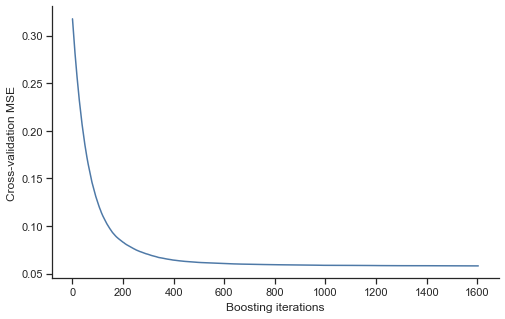

In [26]:
fig, ax = plt.subplots(figsize=(8,5))

plt.plot(history['l2-mean'])

ax.set_ylabel('Cross-validation MSE')
ax.set_xlabel('Boosting iterations')

sns.despine()
plt.show()

## 4.4 Hyperparameter optimisation

Hyperparameter optimisation is one of the most difficult aspects of boosting, as we have many hyperparameters to select.

In general, it's useful to keep the learning rate fixed for hyperparameter optimisation. Smaller learning rates tend to improve performance, but increase the required number of trees and the computational cost. Therefore, we choose the learning rate according to the computational budget. It's common to set a higher learning rate to speed up hyperparameter optimisation and reduce it later to fit the final version of the model.

The next cell implements a general approach for optimising the hyperparameters, taking advantage of early stopping. 

In [34]:
# Need to refresh the dataset for Optuna to work

train_data = lgb.Dataset(X_train, y_train)
valid_data = lgb.Dataset(X_valid, y_valid, reference = train_data)

In [34]:
import optuna
from optuna.samplers import TPESampler

def objective(trial):
    
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05, 
        'verbose': -1,
        'feature_pre_filter': False,
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10), 
        'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10), 
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.5, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128), 
    }
    
    # Cross-validation 
    history = lgb.cv(params, train_data, num_boost_round=5000, 
                     nfold=5, stratified=False, early_stopping_rounds=50)
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['l2-mean']))
    
    return history['l2-mean'][-1] # returns CV error for the best trial

sampler = TPESampler(seed = 42) 
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=500, timeout=120)  

# Important! The higher the timeout, the better the chances of finding a good configuration. 
# The time budget should be much higher in a real application.

[I 2021-10-17 16:30:22,750] A new study created in memory with name: no-name-b3ee9a04-676b-4bfd-b4ca-8966db7bb93b
[I 2021-10-17 16:30:25,376] Trial 0 finished with value: 0.05993075141136621 and parameters: {'num_leaves': 25, 'lambda_l1': 3.6010467344475403, 'lambda_l2': 0.038720902953704193, 'bagging_fraction': 0.7993292420985183, 'bagging_freq': 2, 'feature_fraction': 0.5779972601681014, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.05993075141136621.
[I 2021-10-17 16:30:26,677] Trial 1 finished with value: 0.06093092323582927 and parameters: {'num_leaves': 56, 'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682, 'bagging_fraction': 0.5102922471479012, 'bagging_freq': 10, 'feature_fraction': 0.9162213204002109, 'min_data_in_leaf': 28}. Best is trial 0 with value: 0.05993075141136621.
[I 2021-10-17 16:30:27,784] Trial 2 finished with value: 0.061930170308729514 and parameters: {'num_leaves': 13, 'lambda_l1': 4.4734294104626844e-07, 'lambda_l2': 5.4724296420321

[I 2021-10-17 16:31:02,406] Trial 22 finished with value: 0.05855653271695149 and parameters: {'num_leaves': 46, 'lambda_l1': 0.002921486270567475, 'lambda_l2': 0.0036999976140790537, 'bagging_fraction': 0.9387524536898251, 'bagging_freq': 1, 'feature_fraction': 0.8973581509473696, 'min_data_in_leaf': 15}. Best is trial 10 with value: 0.05669272884624647.
[I 2021-10-17 16:31:04,576] Trial 23 finished with value: 0.057044737826935796 and parameters: {'num_leaves': 34, 'lambda_l1': 3.3981062673545856e-05, 'lambda_l2': 1.0982379428823716, 'bagging_fraction': 0.8913716564612038, 'bagging_freq': 2, 'feature_fraction': 0.802408605042417, 'min_data_in_leaf': 2}. Best is trial 10 with value: 0.05669272884624647.
[I 2021-10-17 16:31:06,624] Trial 24 finished with value: 0.058441644508849436 and parameters: {'num_leaves': 60, 'lambda_l1': 0.006473099709620966, 'lambda_l2': 7.584308632549435, 'bagging_fraction': 0.959152570468181, 'bagging_freq': 4, 'feature_fraction': 0.8929840715032011, 'min_da

[I 2021-10-17 16:31:47,454] Trial 45 finished with value: 0.057618962110430216 and parameters: {'num_leaves': 40, 'lambda_l1': 0.002428600147090167, 'lambda_l2': 0.06003532833205174, 'bagging_fraction': 0.92612167923313, 'bagging_freq': 3, 'feature_fraction': 0.6815010192907149, 'min_data_in_leaf': 14}. Best is trial 10 with value: 0.05669272884624647.
[I 2021-10-17 16:31:48,491] Trial 46 finished with value: 0.0615965217910754 and parameters: {'num_leaves': 30, 'lambda_l1': 2.100888559583888e-05, 'lambda_l2': 8.312813348101393, 'bagging_fraction': 0.5212015197443293, 'bagging_freq': 10, 'feature_fraction': 0.8217960522933832, 'min_data_in_leaf': 27}. Best is trial 10 with value: 0.05669272884624647.
[I 2021-10-17 16:31:49,724] Trial 47 finished with value: 0.059096216899387356 and parameters: {'num_leaves': 21, 'lambda_l1': 0.012170904151124807, 'lambda_l2': 0.5707474981818252, 'bagging_fraction': 0.8802885472858404, 'bagging_freq': 4, 'feature_fraction': 0.625751445404599, 'min_data_

We can retrieve the best parameters as follows.

In [27]:
params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
params 

Number of boosting iterations: 314 

Best parameters:


{'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'num_leaves': 49,
 'lambda_l1': 0.34448638726962943,
 'lambda_l2': 2.569881079449741e-06,
 'bagging_fraction': 0.7991987707634133,
 'bagging_freq': 8,
 'feature_fraction': 0.7922287095621835,
 'min_data_in_leaf': 11}

In [56]:
num_trees = 314
params = {'objective': 'regression',
          'boosting_type': 'gbdt',
          'learning_rate': 0.05,
          'num_leaves': 49,
          'lambda_l1': 0.34448638726962943,
          'lambda_l2': 2.569881079449741e-06,
          'bagging_fraction': 0.7991987707634133,
          'bagging_freq': 8,
          'feature_fraction': 0.7922287095621835,
          'min_data_in_leaf': 11}

With some many hyperparameters, it's helpful to know which ones make the most difference for the quality of the model. The `get_param_importances` function from Optuna does exactly this.  

In [28]:
importance = optuna.importance.get_param_importances(study)

importance

OrderedDict([('min_data_in_leaf', 0.5919032056001015),
             ('bagging_freq', 0.10695505734580353),
             ('lambda_l1', 0.09490556266268717),
             ('num_leaves', 0.07990953681289918),
             ('feature_fraction', 0.07200954177662965),
             ('bagging_fraction', 0.03926167519325754),
             ('lambda_l2', 0.015055420608621464)])

Optuna also has a LightGBM integration with useful features. For example, we can modify the above code to prune unpromising trials.

In [57]:
from optuna.integration import LightGBMPruningCallback

def objective(trial):
    
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'verbosity': -1,
        'num_leaves': trial.suggest_int('num_leaves', 2, 64),
        'lambda_l1': trial.suggest_loguniform('lambda_l1',  1e-8, 10.0), 
        'lambda_l2': trial.suggest_loguniform('lambda_l2',  1e-8, 10.0), 
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'feature_fraction':  trial.suggest_uniform('feature_fraction', 0.3, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 128)
    }
    
    # Instantiate pruning callback
    pruning_callback =  LightGBMPruningCallback(trial, 'l2')
    
    # LightGBM cross-validation
    history = lgb.cv(params, train_data, num_boost_round = 5000, 
                 nfold = 5, stratified = False, early_stopping_rounds = 100,
                 callbacks = [pruning_callback])
    
    # Save full set of parameters
    trial.set_user_attr('params', params)
    
    # Save the number of boosting iterations selected by early stopping
    trial.set_user_attr('num_boost_round', len(history['l2-mean']))
    
    return history['l2-mean'][-1] # returns CV error for the best trial

# Instantiating the sampler to set the random seed
sampler = TPESampler(seed=42) 

# Instantiating the pruner
# The min_resource should be the minimum number of trees required to reasonably judge performance
# This can be tricky to get it right for boosting
# See the notes in the documentation:
# https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html
pruner = optuna.pruners.HyperbandPruner(min_resource = 100, max_resource = 'auto', reduction_factor = 3)

# A simpler alternative is the median pruner
# This method prunes trials with partial performance below the median of previous trials 
# pruner = optuna.pruners.MedianPruner(n_startup_trials = 10, n_warmup_steps = 500, interval_steps = 5)

study = optuna.create_study(direction='minimize', sampler = sampler, pruner = pruner)
study.optimize(objective, n_trials=500, timeout= 120)

[I 2021-10-17 15:38:21,897] A new study created in memory with name: no-name-c187ccdd-a7ec-4f9c-a0c0-0934dfe07de4
[I 2021-10-17 15:39:00,762] Trial 0 finished with value: 0.06423647211421116 and parameters: {'num_leaves': 25, 'lambda_l1': 3.6010467344475403, 'lambda_l2': 0.038720902953704193, 'bagging_fraction': 0.7993292420985183, 'bagging_freq': 2, 'feature_fraction': 0.40919616423534183, 'min_data_in_leaf': 8}. Best is trial 0 with value: 0.06423647211421116.
[I 2021-10-17 15:39:13,996] Trial 1 finished with value: 0.06093092323582927 and parameters: {'num_leaves': 56, 'lambda_l1': 0.002570603566117598, 'lambda_l2': 0.023585940584142682, 'bagging_fraction': 0.5102922471479012, 'bagging_freq': 10, 'feature_fraction': 0.8827098485602951, 'min_data_in_leaf': 28}. Best is trial 1 with value: 0.06093092323582927.
[I 2021-10-17 15:39:15,257] Trial 2 pruned. Trial was pruned at iteration 100.
[I 2021-10-17 15:39:22,768] Trial 3 finished with value: 0.06170280838744925 and parameters: {'num

Observe how pruning allowed Optuna to execute more trials within the allocated time. In practice, HyperBand needs [more trials](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.pruners.HyperbandPruner.html) to work well with TPE sampling. 

In [30]:
params = study.best_trial.user_attrs['params']
num_trees = study.best_trial.user_attrs['num_boost_round']

print(f'Number of boosting iterations: {num_trees} \n')

print('Best parameters:')
params 

Number of boosting iterations: 272 

Best parameters:


{'objective': 'regression',
 'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'num_leaves': 38,
 'lambda_l1': 1.3517397175465322e-08,
 'lambda_l2': 4.124849612281494e-07,
 'bagging_fraction': 0.9390866257698176,
 'bagging_freq': 4,
 'feature_fraction': 0.7193249555070594,
 'min_data_in_leaf': 20}

In [59]:
num_trees = 272
params = {'objective': 'regression',
          'boosting_type': 'gbdt',
          'learning_rate': 0.05,
          'num_leaves': 38,
          'lambda_l1': 1.3517397175465322e-08,
          'lambda_l2': 4.124849612281494e-07,
          'bagging_fraction': 0.9390866257698176,
          'bagging_freq': 4,
          'feature_fraction': 0.7193249555070594,
          'min_data_in_leaf': 20}

The `LightGBMTunerCV` function implements an efficient algorithm for tuning LightGBM that has been found to work well in Kaggle competitions.`LightGBMTuner` is a similar function that uses a validation set. Instead of jointly optimising the hyperparameters as above, this implementation optimises one hyperparameter at time. The optimised hyperparameters are `lambda_l1`, `lambda_l2`, `num_leaves`, `feature_fraction`, `bagging_fraction`, `bagging_freq` and `min_data_in_leaf`.  


This method runs faster than the more generic hyperparameter optimisation procedure from above, making it a good starting point. Either algorithm can perform better depending on the problem. 

In [61]:
import optuna.integration.lightgbm as lgb

dtrain = lgb.Dataset(X_train, y_train)
    
params = {
    'objective': 'regression',
    'metric': 'l2',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'verbosity': -1,
    }

tuner = lgb.LightGBMTunerCV(params, dtrain, num_boost_round = 5000, early_stopping_rounds = 100, 
                            verbose_eval=1000, time_budget = 120, nfold=5, stratified = False)

tuner.run()

[I 2021-10-17 15:44:09,029] A new study created in memory with name: no-name-31d7dab0-80eb-4f4f-9dda-22541ee724c2
  0%|          | 0/5 [00:00<?, ?it/s]


Here are the selected hyperparameters.

In [32]:
print('Best params:')

tuner.best_params

Best params:


{'objective': 'regression',
 'metric': 'l2',
 'boosting_type': 'gbdt',
 'learning_rate': 0.05,
 'verbosity': 0,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 0.6,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

Finally, the next cell trains the final version of the LightGBM model for this tutorial. To get the final hyperparameters, I ran the Optuna study with pruning for ten minutes. 

In [62]:
import lightgbm as lgb

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 45,
    'lambda_l1': 0.027109795180157614,
    'lambda_l2': 1.3211122996540583e-06,
    'bagging_fraction': 0.9303390497096511,
    'bagging_freq': 8,
    'feature_fraction': 0.6954068017048125,
    'min_data_in_leaf': 2
}

lgbm = lgb.train(params, train_data, num_boost_round = 3996)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 4128, number of used features: 8
[LightGBM] [Info] Start training from score 0.573084


# 5. Benchmark Models

## 5.1 Linear Regression

In [63]:
# This code is  just for running - identical to earlier tutorial

ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

## 5.2 Regression Tree


In [64]:
# This code is  just for running - identical to earlier tutorial

from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(min_samples_leaf=5)
path = model.cost_complexity_pruning_path(X_train, y_train)
alphas = path.ccp_alphas

search_space = {
    'ccp_alpha': alphas,
}

tree_search = GridSearchCV(model, search_space, cv = 5)
tree_search.fit(X_train, y_train)

tree = tree_search.best_estimator_

print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'ccp_alpha': 0.0001530239269508433} 



## 5.3 Random forest

In [65]:
# This code is  just for running - identical to earlier tutorial

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=1000, max_features = 3, min_samples_leaf= 1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_features=3, n_estimators=1000)

# 6. Model selection

The following table shows the validation results. Boosting clearly outperforms the linear regression, regression tree, and random forest.

LightGBM is the best model among the boosting variations, which is to be expected since we put more effort into it. CatBoost lived up to the promise of performing well with default settings, at least for this problem.  XGBoost probably needs more tuning. The results are consistent with  three packages tend to perform better than scikit-learn, as seen in these results. 

An important note: a complete analysis based on all the tutorials so far should also include TPOT, GAM, Explainable Boosting Machine, and model stacking.  

In [66]:
# Auxiliary code - important to understand but similar to previous tutorials

columns=['Test RMSE', 'Test R$^2$', 'Test MAE']
rows=['Linear regression', 'Regression tree', 'Random forest', 'GBM', 'Hist GBM',
      'XGBoost', 'CatBoost', 'LightGBM']

results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods = [ols, tree, rf, gb, hgb, xgbst, cb, lgbm]

for i, method in enumerate(methods):

    y_pred = method.predict(X_valid)
    
    # The linear regression model is severely affected by outliers
    if method == ols:
        y_pred[y_pred>y_train.max()] = y_train.max()
        y_pred[y_pred<y_train.min()] = y_train.min()
    
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_valid, y_pred))
    results.iloc[i,1] = r2_score(y_valid, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_valid, y_pred)

results.round(3)

,Test RMSE,Test R$^2$,Test MAE
Linear regression,0.335,0.655,0.248
Regression tree,0.306,0.711,0.222
Random forest,0.253,0.803,0.182
GBM,0.232,0.834,0.162
Hist GBM,0.234,0.831,0.166
XGBoost,0.230,0.837,0.162
CatBoost,0.227,0.841,0.160
LightGBM,0.225,0.844,0.157


### Boosting

https://medium.com/greyatom/a-quick-guide-to-boosting-in-ml-acf7c1585cb5

https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d

------------------------

<center><img src="https://i.redd.it/igc0n2r7svu61.png" width="400"></center>

Answer: https://old.reddit.com/r/learnmachinelearning/comments/mwqgut/data_science_interview_question_asked_by_apple/gvkr5a9/